# Perceptual loss

В задаче классификации цвет пикселя это достаточно слабый признак и "близость" в таком пространстве несет мало информации. В тот раз мы перешли к сравнению признаков, которые выучила нейронная сеть -- т.е. к выходам ее слоев.

Т.е. использовать не попиксельную разницу а разницу между выходами определенных слоев обученной нейронной сети для исходного изображения и сгенерированного. Сложно представить к чему это нас приведет, поэтому давайте скорее попробуем!

In [1]:
import tensorflow as tf
import IPython.display as display
import time
from tqdm import tqdm


In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#@title

def clip_0_1(image):
    """
    Мы хотим уметь отображать нашу полученную картинку, а для этого ее значения должны 
    находится в промежутке от 0 до 1. Наш алгоритм оптимизации этого нигде не учитывает
    поэтому к полученному изображению мы будем применять "обрезку" по значению
    
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    Данная функция считывает изображение с диска и приводит его к такому размеру,
    чтобы бОльшая сторона была равна max_dim пикселей.

    Для считывания изображения воспользуемся функциями tensorflow.
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    Функция для отрисовки изображения
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Загрузим картинку на диск и отобразим ниже:

In [4]:
url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
image_path = tf.keras.utils.get_file('stones.jpg', url)

1875968/1866097 [==============================] - 0s 0us/step


(0.9996431, (1, 170, 256, 3))

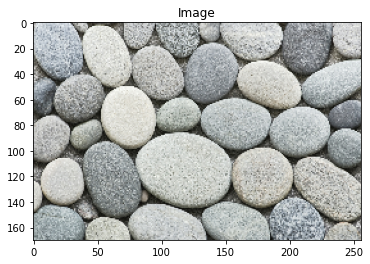

In [5]:
content_image = load_img(image_path, 256)
imshow(content_image, 'Image')
content_image.numpy().max(), content_image.numpy().shape # убедимся, что картинка нужного размера, а также значения 
                                                         # лежат в промежутке от 0 до 1

# Feature extraction

Для начала загрузим обученную на датасете ImageNet (тот, в котором миллион изображений объектов тысячи разных классов) сеть VGG.  Нам уже известно, что она помимо предсказания классов, умеет выделять признаки разной сложности в зависимости от слоя. В дальнейшем мы будем обращаться к ее слоям по именам, поэтому посмотрим какие имена присутствуют:

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Благодаря Keras мы можем удобным способом получать выходы необходимого слоя. После того как мы получим доступ к выходам слоя(-ев), мы должны создать tf.keras.Model у которой входом будет вход VGG, а выходом -- выбранные слой, с которого мы хотим “забрать” признаки. Пусть это будет например слой “block3_conv2”. Мы еще увидим на что влияет выбор слоя. Мы делали что-то похожее когда рассматривали Functional API.


In [7]:
outputs = [vgg.get_layer('block3_conv2').output]
model = tf.keras.Model([vgg.input], outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Обернем это в функцию для дальнейшего использования:

In [8]:
def get_vgg_layers_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

get_vgg_layers_model(["block3_conv1"]).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Реализуем класс, который будет при вызове извлекать из картинки признаковое описание картинки, полученное на указанном слое VGG.

In [9]:
class FeatureExtractor:
  def __init__(self, layers):
    self.vgg_outputs_model =  get_vgg_layers_model(layers)
    self.vgg_outputs_model.trainable = False
    self.content_layers = layers
    
  def __call__(self, inputs):
    """
    На входе 4х мерный тензор (картинка). Значения пикселей ограничены 0..1!

    На выходе: {"имя слоя": тензор выхода этого слоя}
    """
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.) # VGG препроцессинг
    outputs = self.vgg_outputs_model(preprocessed_input)
    features_dict = {name:value for name, value in zip(self.content_layers, outputs)}

    return features_dict

In [10]:
content_layers = ['block2_conv2']
extractor = FeatureExtractor(content_layers)
results = extractor(content_image)
print(results.keys())

dict_keys(['block2_conv2'])


In [11]:
print(results["block2_conv2"].shape)

(85, 128, 128)


#  Определение лосса

Для вычисления лосса нам нужно знать с чем сравнивать признаки сгенерированного изображения.
Мы можем их вычислить один раз для оригинального изображения и затем сравнивать с ними.

In [12]:
# Переменная target_features -- содержит словарь в котором сохранены выходы сети примененной к оригинальной картинке
# Это нам нужно для вычисления лосса -- в нем мы будем считать как сильно признаки сгенерированного изображения
# отличаются от признаков оригинального
target_features = extractor(content_image)

Определим лосс:

In [13]:
def loss(image): 
    """
    Получаем картинку, вычисляем признаки с помощью класса FeatureExtractor. 
    Сравниваем их с target_features с помощью MeanSquaredError.
    """
    current_features = extractor(image)
    loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features[name], target_features[name]) 
                                     for name in target_features.keys()])
    loss *= 1. / len(target_features.keys())

    # для того чтобы результаты были больше похожи на настоящую картинку -- добавим регуляризацию
    # в реальных картинках цвета меняются плавно и нет цветового шума (шумные цветные пиксели поверх картинки)
    # при оптимизации мы часто будем получать такие результаты -- чтобы их уменьшать будуем штрафовать за такие резкие перепады цветов.
    # tota_variation -- нам в этом поможет
    loss += tf.image.total_variation(image)*1e-2
    return loss

Перейдем к реализации train_step. Он аналогичен прошлому уроку. Обращаю внимание, что после шага оптимизации изменяется только картинка. **Веса сети VGG не меняются**

In [14]:
def train_step(image, loss_func, optimizer):
    """
    Шаг оптимизации мы реализуем вручную (без .fit()). Такая реализация будет
    нам полезна в дальнейшем.

    """
    
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    optimizer.apply_gradients([(grad, image)]) # шаг градиентного спуск. в случае  GD: image = image - lambda*dLoss/dImage
                                                   # картинка после этого шага изменилась!
    image.assign(clip_0_1(image)) # ~ image = clip_0_1(image), "обрезаем" неправильные значения
    return loss.numpy()

In [15]:
def show_pair(original, generated, title=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(original, 'Original Image')
    plt.subplot(1, 2, 2)
    imshow(generated, title)

# Собираем все вместе

40960/25988 [===============================================] - 0s 0us/step


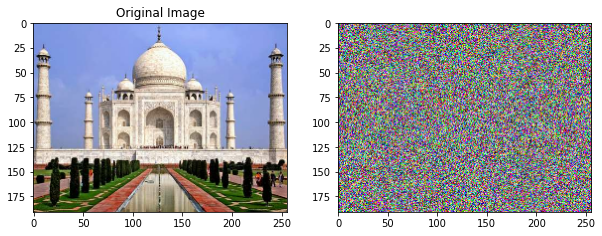

In [16]:
# block2_conv2, block4_conv1, block5_conv3
#url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
url = "https://cdn.britannica.com/s:500x350/86/170586-120-7E23E561.jpg"
image_path = tf.keras.utils.get_file('taj.jpg', url)
content_image = load_img(image_path, 256)

feature_layers = ['block5_conv3']
extractor = FeatureExtractor(feature_layers)
target_features = extractor(content_image)

image = tf.Variable(np.random.rand(*content_image.numpy().shape).astype(np.float32))
opt = tf.keras.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)


# сделаем шаг оптимизации -- убедимся что все работает без ошибок.
train_step(image, loss_func=loss, optimizer=opt)
show_pair(content_image, image)

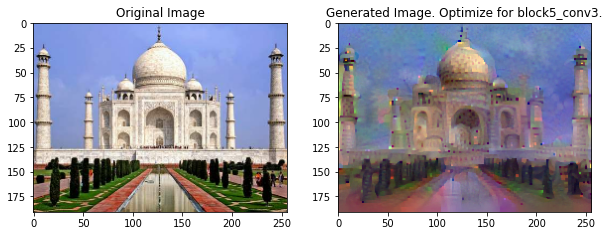

In [17]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)
  show_pair(content_image, image, f"Generated Image. Optimized for {feature_layers[0]}. Train step: {step}")
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))
display.clear_output(wait=True)
show_pair(content_image, image, f"Generated Image. Optimize for {feature_layers[0]}.")
plt.savefig(f"result_{feature_layers[0]}.png")


1. Если мы приближаем картинки в пространстве выходов начальных слоев, то картинки получаются практически идентичными
2. Выбирая более поздние слои мы можем увидеть, что информация о цвете и текстуре начинает теряться и результат оптимизации лишь отдаленно напоминает оригинал -- т.е. остается только контент.

Ниже иллюстрация из [статьи](https://arxiv.org/abs/1603.08155), в которой авторы проводили похожий эксперимент. Вот, что у них получилось.

<img src="https://drive.google.com/uc?export=view&id=1Ap-7fgpRidmTdtFZXXaH1F_BV2h52AN9" width=600>

Выбирая ранние слои -- мы получали по сути исходное изображение. А более поздние давали хоть и интересные результаты, но они теряли информацию о текстуре. Это нам не подходит.

Но мы получили интересные результаты и ввели новый лосс - Perceptual Loss.

# Практика

Получите результат оптимизации для других картинок и разных слоев для сравнения признаков.

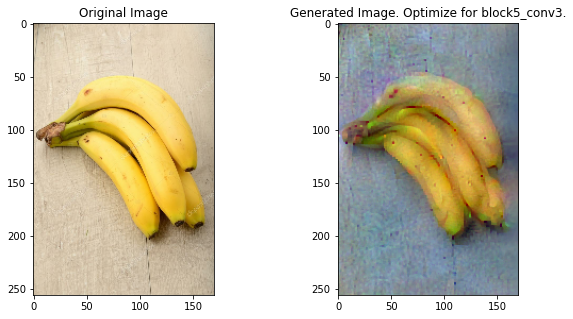

In [24]:
# block2_conv2, block4_conv1, block5_conv3
#url = https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BBV2vkb.img?h=417&w=624&m=6&q=60&o=f&l=f&x=858&y=370
url = "https://st2.depositphotos.com/3254329/5413/i/950/depositphotos_54133239-stock-photo-bananas-on-a-table.jpg"
image_path = tf.keras.utils.get_file('bananas.jpg', url)
content_image = load_img(image_path, 256)

feature_layers = ['block5_conv3']
extractor = FeatureExtractor(feature_layers)
target_features = extractor(content_image)
image = tf.Variable(np.random.rand(*content_image.numpy().shape).astype(np.float32))
opt = tf.keras.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)
  show_pair(content_image, image, f"Generated Image. Optimized for {feature_layers[0]}. Train step: {step}")
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))
display.clear_output(wait=True)
show_pair(content_image, image, f"Generated Image. Optimize for {feature_layers[0]}.")
plt.savefig(f"result_{feature_layers[0]}.png")